In [1]:
import sys
sys.path.append('../../') 

In [14]:

%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import seaborn as sns
sns.set()

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# from fit_and_predict import fit_and_predict
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy.random as npr
import numpy.linalg as npl

from scipy.stats import norm as normal
from scipy.stats import laplace as laplace
from scipy.optimize import curve_fit

In [4]:
aggregate_by_state = False
# outcome_type = 'cases'

In [5]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(data_dir = '../../data/')
df = df.sort_values('#Deaths_3/30/2020', ascending=False)
# outcome_cases = load_data.outcome_cases # most recent day
# outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)
very_important_vars = ['PopulationDensityperSqMile2010',
#                        'MedicareEnrollment,AgedTot2017',
                       'PopulationEstimate2018',
                       '#ICU_beds',
                       'MedianAge2010',
                       'Smokers_Percentage',
                       'DiabetesPercentage',
                       'HeartDiseaseMortality',
                        '#Hospitals'
#                        'PopMale60-642010',
#                         'PopFmle60-642010',
#                          'PopMale65-742010',
#                          'PopFmle65-742010',
#                          'PopMale75-842010',
#                          'PopFmle75-842010',
#                          'PopMale>842010',
#                          'PopFmle>842010'
                      ]

In [6]:
df["PopulationEstimate2018"].head()

1841    2278906.0
1803    1432132.0
1824    2582830.0
2941    2233163.0
1831    1628701.0
Name: PopulationEstimate2018, dtype: float64

In [7]:
def sum_lists(list_of_lists):
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    return list(sum_arr)
aggregate_by_state = True
if aggregate_by_state:
    # Aggregate by State
    state_deaths_df = df.groupby('StateNameAbbreviation').deaths.agg(sum_lists).to_frame()
    state_cases_df = df.groupby('StateNameAbbreviation').cases.agg(sum_lists).to_frame()
    state_pop_df = df.groupby('StateNameAbbreviation').PopulationEstimate2018.agg(sum).to_frame()
    sdf =  pd.concat([state_cases_df,state_deaths_df, state_pop_df],axis =1 )

In [8]:
sdf = sdf.reset_index()
sdf.keys()

Index(['StateNameAbbreviation', 'cases', 'deaths', 'PopulationEstimate2018'], dtype='object')

In [9]:
sdf.keys()

Index(['StateNameAbbreviation', 'cases', 'deaths', 'PopulationEstimate2018'], dtype='object')

In [10]:
sdf = sdf.rename(columns={"StateNameAbbreviation": "state", "PopulationEstimate2018": 'population' })


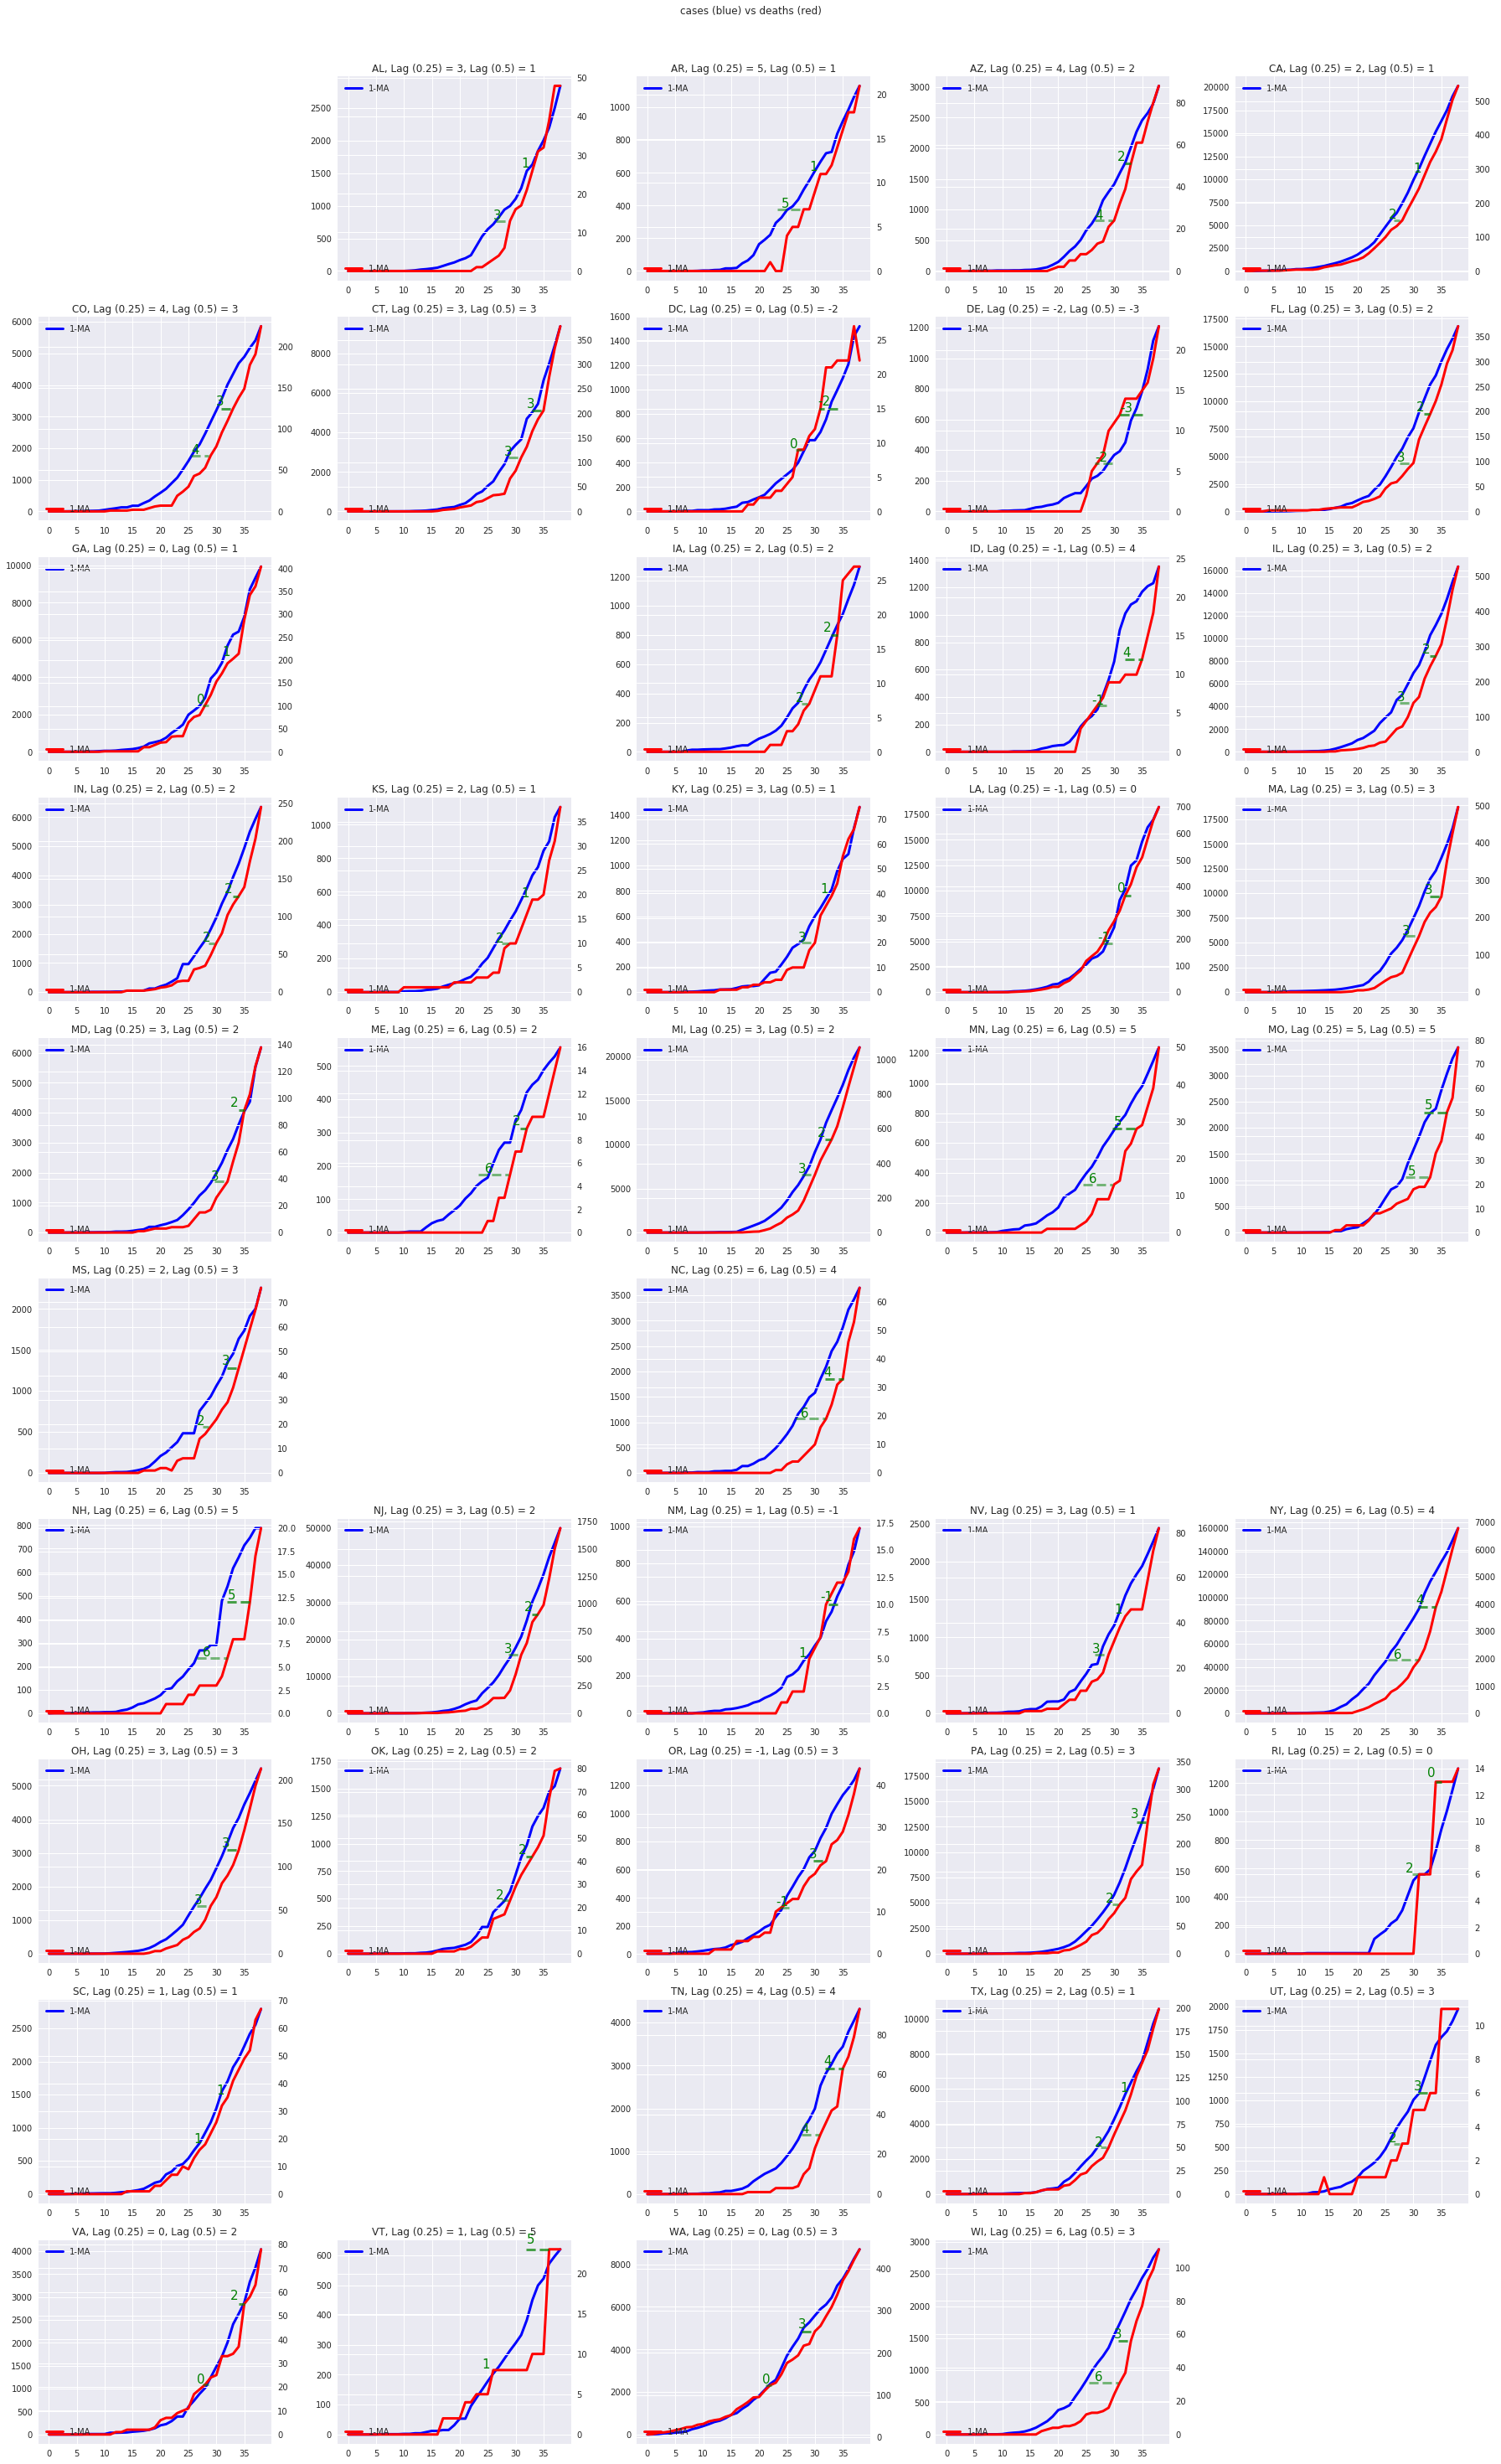

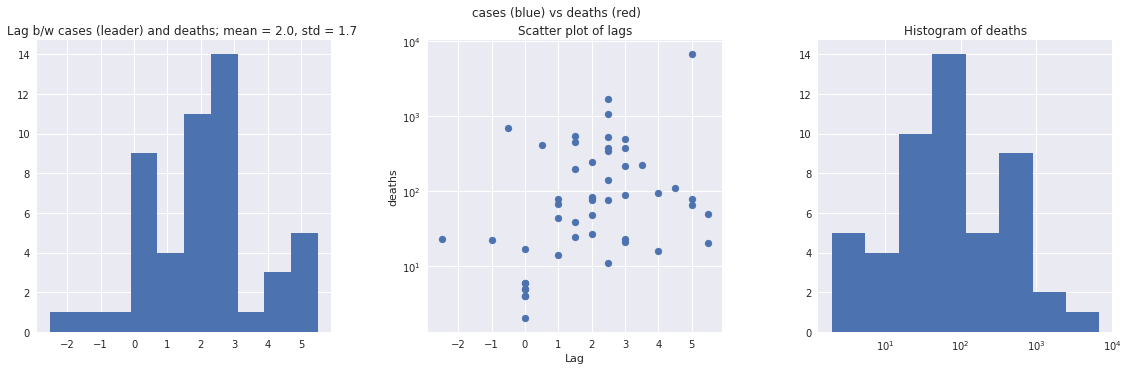

In [90]:
w = 1

f1, f2 = "cases", "deaths" 
num_plot = 50
deltas = np.zeros((num_plot, 2))
feat = np.zeros(num_plot)
f3 = 'deaths'

plt.figure(figsize=[25, 4*num_plot/5])
for j, state in enumerate(sdf.state.unique()[:num_plot]):
    feat[j] = sdf[sdf.state==state]["deaths"][j][-1]
    if feat[j]< 10:
        continue
    plt.subplot(num_plot/5, 5, j+1)
    
    y1 = pd.Series(sdf[sdf.state==state][f1][j][40:])
    plt.plot(y1, color='b', alpha=0.3)
    smooth_y1 =  y1.rolling(window=w)
    smooth_y1 = smooth_y1.mean()
    plt.plot(smooth_y1, color='b', linewidth=3., label='%d-MA'%w)
    x1, x2 = np.argmax(y1), np.argmax(smooth_y1)
#     plt.axvline(x= x2, color='b', alpha=0.6, linestyle='--', linewidth=3.)
#     plt.yscale('log')
    plt.legend(loc='upper left')
    
    ax = plt.gca().twinx()
    
    y2 = pd.Series(sdf[sdf.state==state][f2][j][40:])
    ax.plot(y2, color='r', alpha=0.3)
    smooth_y2 =  y2.rolling(window=w)
    smooth_y2 = smooth_y2.mean()
    ax.plot(smooth_y2, color='r', linewidth=3., label='%d-MA'%w)
    x3, x4 = np.argmax(y2), np.argmax(smooth_y2)
    plt.legend(loc='lower left')

    t1 = np.where(y1>=0.25*max(y1))[0][0]
    t2  = np.where(y2>=0.25*max(y2))[0][0]

    t11 = np.where(y1>=0.5*max(y1))[0][0]
    t22  = np.where(y2>=0.5*max(y2))[0][0]
    
    deltas[j, 0] = t2-t1
    deltas[j, 1] = t22-t11

    plt.axhline(y2[t2], (t1+0.5)/len(y2), (t2-0.5)/len(y2), color='g', linestyle='--', linewidth=3., alpha=0.5, )
    plt.text(x=(t1+t2-3)/2, y=y2[t2]*1.03, s=int(deltas[j, 0]), color='g', fontsize=15)

    plt.axhline(y2[t22], (t11+0.5)/len(y2), (t22-0.5)/len(y2), color='g', linestyle='--', linewidth=3., alpha=0.7, )
    plt.text(x=(t11+t22-3)/2, y=y2[t22]*1.03, s=int(deltas[j, 1]), color='g', fontsize=15)

    plt.title('%s, Lag (0.25) = %d, Lag (0.5) = %d'%(state, deltas[j, 0], deltas[j, 1]))
#     plt.yscale('log')
plt.tight_layout()
plt.suptitle('%s (blue) vs %s (red)'%(f1, f2), y=1.02)
plt.show()

plt.figure(figsize=[16, 5])
plt.subplot(131)
mean_deltas = np.mean(deltas, axis=1)
plt.hist(mean_deltas)
plt.title('Lag b/w %s (leader) and %s; mean = %.1f, std = %.1f '%(f1, f2, np.mean(mean_deltas), np.std(mean_deltas)))
    
plt.subplot(132)
plt.scatter(mean_deltas, feat)
plt.yscale('log')
plt.xlabel('Lag')
plt.ylabel(f3)
plt.title('Scatter plot of lags')

plt.subplot(133)
hist, bins = np.histogram(feat, bins=8)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(feat, bins=logbins)
plt.xscale('log')
plt.title('Histogram of %s'%f3)
plt.suptitle('%s (blue) vs %s (red)'%(f1, f2), y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
sdf["total_deaths"] = feat

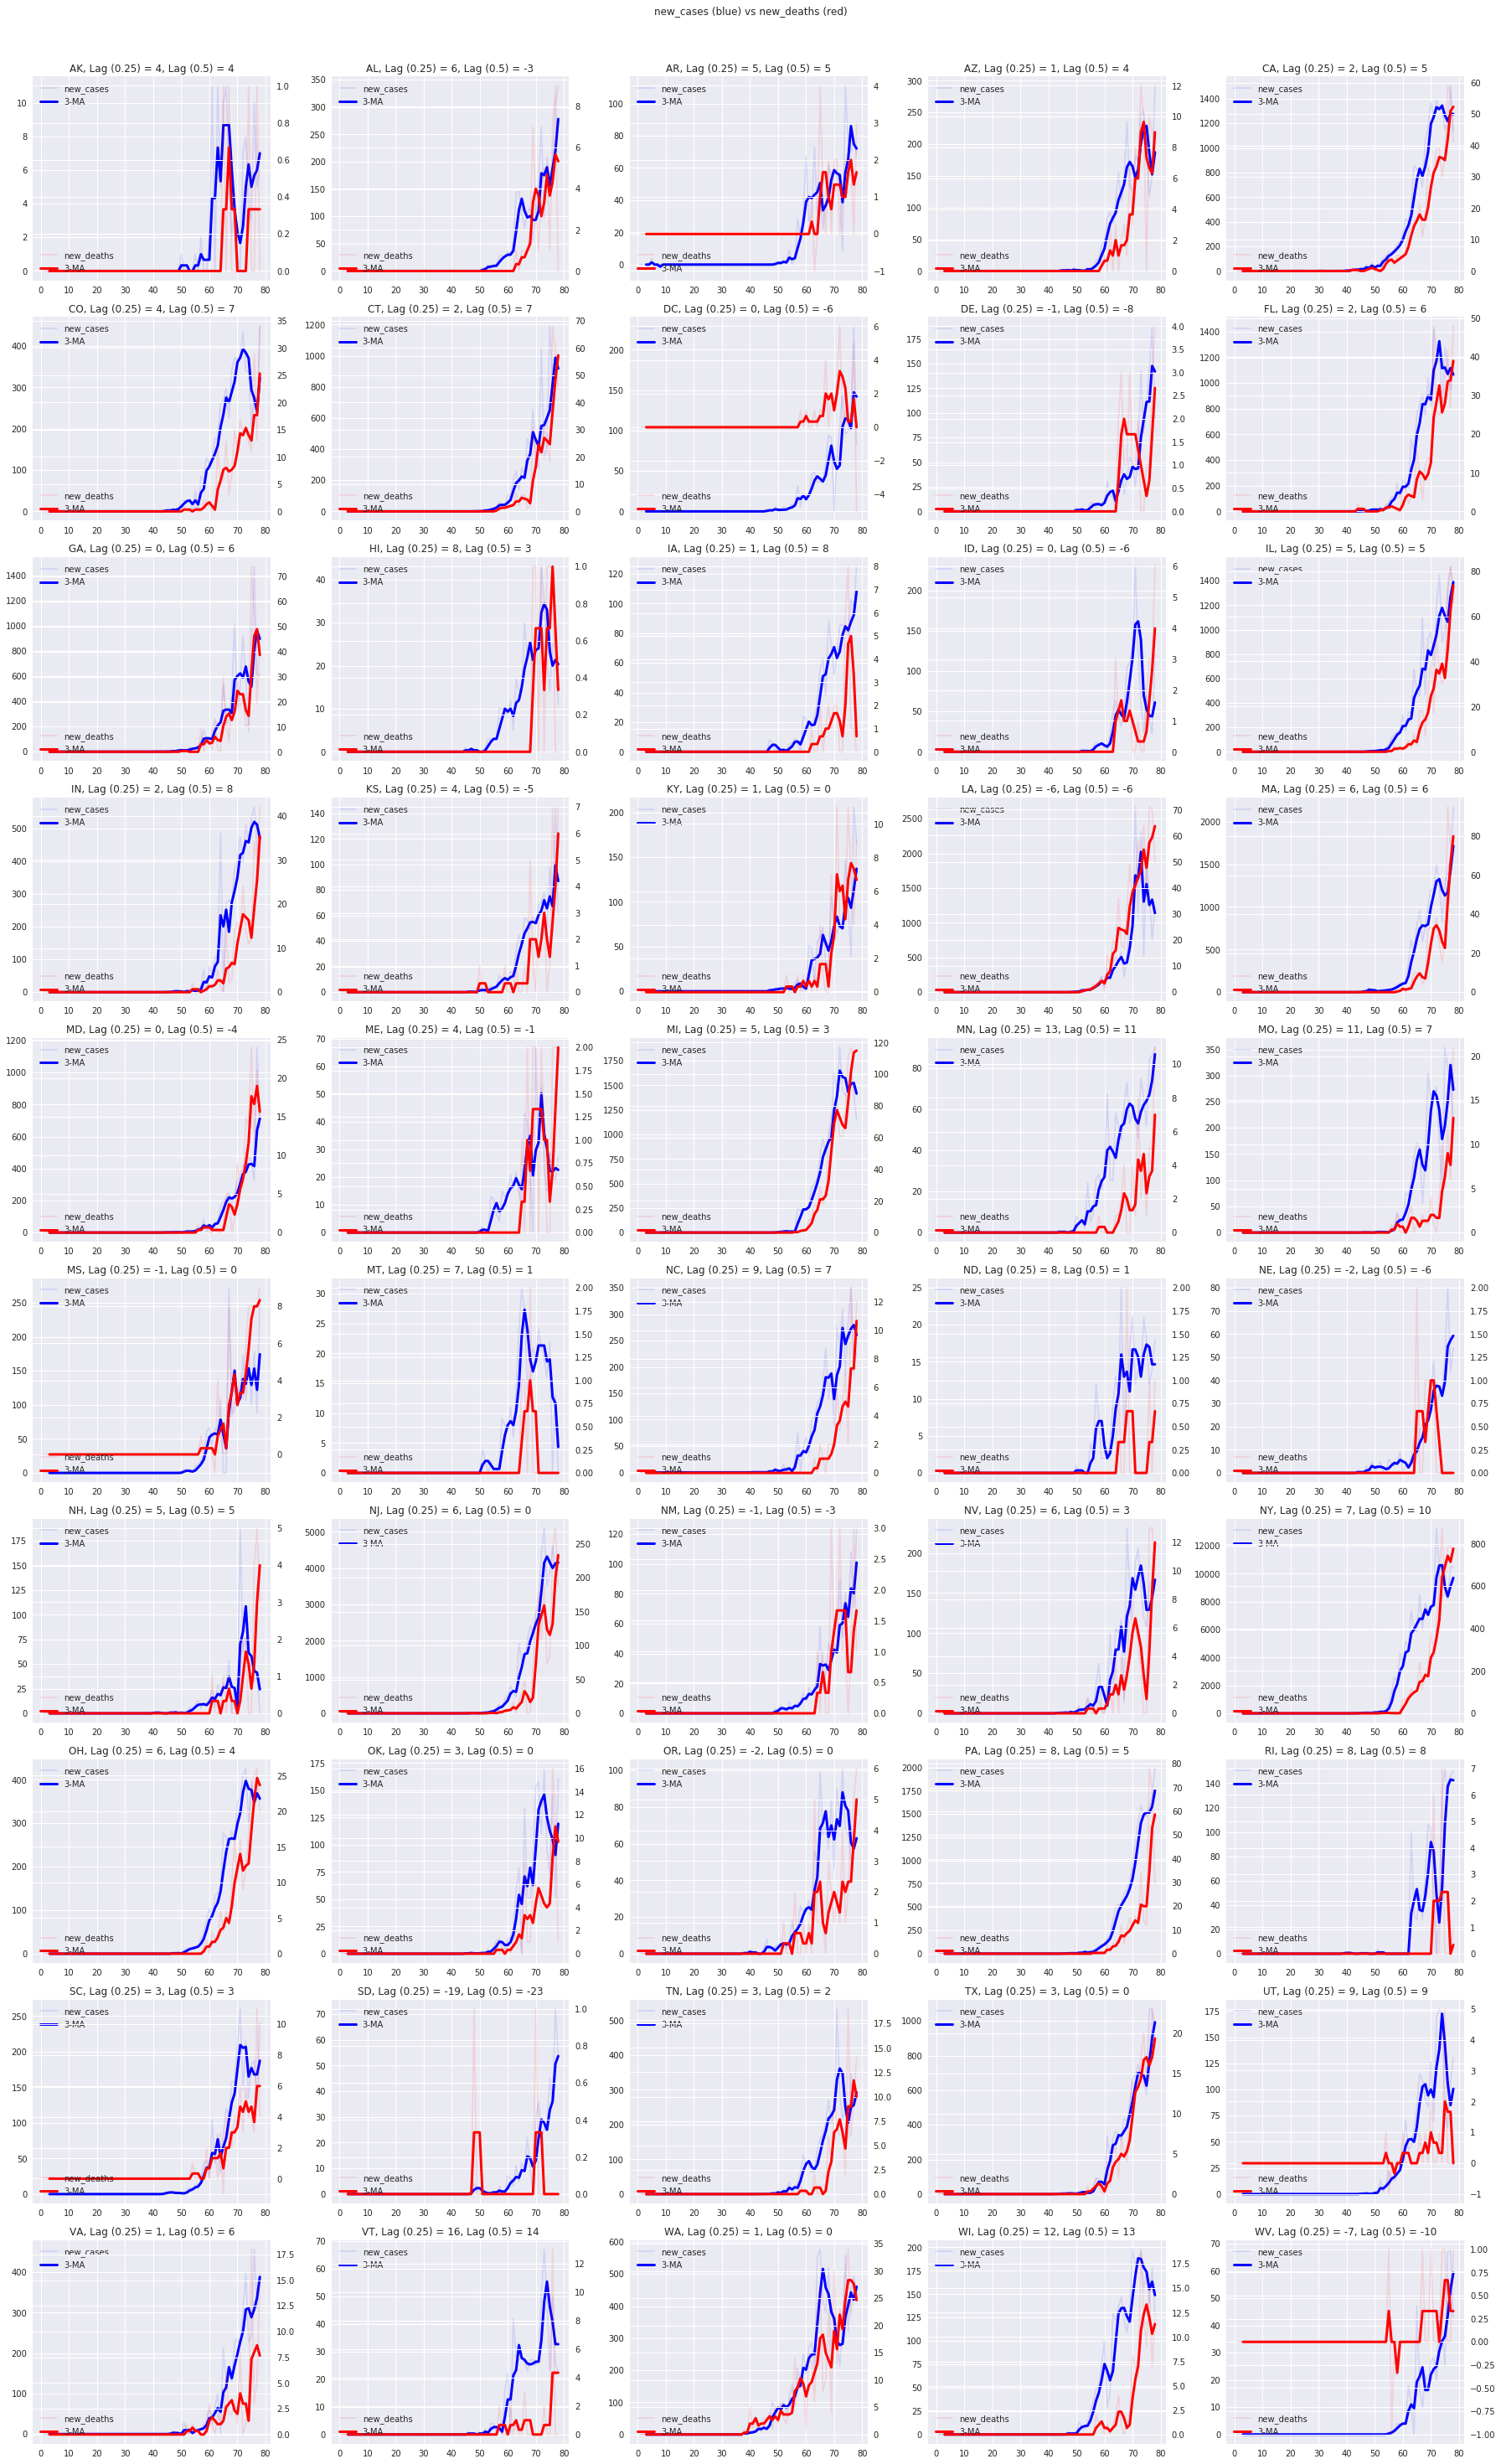

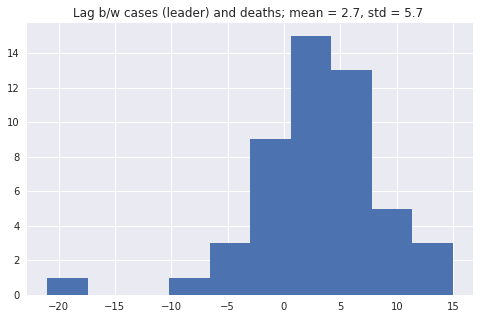

In [71]:
w = 3

prefix = 'new_'
f1, f2 = "cases", "deaths" 
num_plot = 50
deltas = np.zeros((num_plot, 2))

plt.figure(figsize=[25, 4*num_plot/5])
for j, state in enumerate(sdf.state.unique()[:num_plot]):
    plt.subplot(num_plot/5, 5, j+1)
    
    y1 = pd.Series(sdf[sdf.state==state][f1][j])
    if prefix == 'new_':
        y1 = (y1 - y1.shift(1))[1:]
        plt.plot(y1, color='b', alpha=0.1, label='%s'%prefix+f1)
    smooth_y1 =  y1.rolling(window=w)
    smooth_y1 = smooth_y1.mean()
    plt.plot(smooth_y1, color='b', linewidth=3., label='%d-MA'%w)
    x1, x2 = np.argmax(y1), np.argmax(smooth_y1)
#     plt.axvline(x= x2, color='b', alpha=0.6, linestyle='--', linewidth=3.)
#     plt.yscale('log')
    plt.legend(loc='upper left')
    
    ax = plt.gca().twinx()
    
    y2 = pd.Series(sdf[sdf.state==state][f2][j])
    if prefix == 'new_':
        y2 = (y2 - y2.shift(1))[1:]
        ax.plot(y2, color='r', alpha=0.1, label='%s'%prefix+f2)
    smooth_y2 =  y2.rolling(window=w)
    smooth_y2 = smooth_y2.mean()
    ax.plot(smooth_y2, color='r', linewidth=3., label='%d-MA'%w)
    
    x3, x4 = np.argmax(y2), np.argmax(smooth_y2)
    plt.legend(loc='lower left')

    t1 = np.where(y1>=0.25*max(y1))[0][0]
    t2  = np.where(y2>=0.25*max(y2))[0][0]

    t11 = np.where(y1>=0.5*max(y1))[0][0]
    t22  = np.where(y2>=0.5*max(y2))[0][0]
    
    deltas[j, 0] = t2-t1
    deltas[j, 1] = t22-t11

#     plt.axhline(y2[t2], (t1+0.5)/len(y2), (t2-0.5)/len(y2), color='g', linestyle='--', linewidth=3., alpha=0.5, )
#     plt.text(x=(t1+t2-3)/2, y=y2[t2]*1.03, s=int(deltas[j, 0]), color='g', fontsize=15)

#     plt.axhline(y2[t22], (t11+0.5)/len(y2), (t22-0.5)/len(y2), color='g', linestyle='--', linewidth=3., alpha=0.7, )
#     plt.text(x=(t11+t22-3)/2, y=y2[t22]*1.03, s=int(deltas[j, 1]), color='g', fontsize=15)

    plt.title('%s, Lag (0.25) = %d, Lag (0.5) = %d'%(state, deltas[j, 0], deltas[j, 1]))
#     plt.yscale('log')
plt.tight_layout()
plt.suptitle('%s (blue) vs %s (red)'%(prefix+f1, prefix+f2), y=1.02)
plt.show()

plt.figure(figsize=[8, 5])
# plt.subplot(131)
mean_deltas = np.mean(deltas, axis=1)
plt.hist(mean_deltas)
plt.title('Lag b/w %s (leader) and %s; mean = %.1f, std = %.1f '%(f1, f2, np.mean(mean_deltas), np.std(mean_deltas)))

# feat = np.zeros(len(dfg.groups.keys()))
# f3 = 'total_deaths'
# for j, grp in enumerate(dfg.groups.keys()):
#     group = dfg.get_group(grp).reset_index()
#     feat[j] = group[f3].tail(1).values[0]
# plt.subplot(132)
# plt.scatter(mean_deltas, feat)
# plt.yscale('log')
# plt.xlabel('Lag')
# plt.ylabel(f3)
# plt.title('Scatter plot of lags')

# plt.subplot(133)
# hist, bins = np.histogram(feat, bins=8)
# logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
# plt.hist(feat, bins=logbins)
# plt.xscale('log')
# plt.title('Histogram of %s'%f3)
# plt.suptitle('%s (blue) vs %s (red)'%(f1, f2), y=1.02)
# plt.tight_layout()
plt.show()

## Laplace Gaussian Modeling

In [93]:
sdf.state.unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [12]:
def model_laplace(t, p, a, b):
    return(p*laplace.cdf(a*(t-b)))
def model_gauss(t, p, a, b):
    return(p*normal.cdf(a*(t-b)))
def model_mixture_laplace_gaussian(t, p, a, b, p1, a1, b1):
    return( p * laplace.cdf(a*(t-b)) + p1 * normal.cdf(a1*(t-b1)))

def model_mixture_gaussian_gaussian(t, p, a, b, p1, a1, b1):
    return( p * normal.cdf(a*(t-b)) + p1 * normal.cdf(a1*(t-b1)))


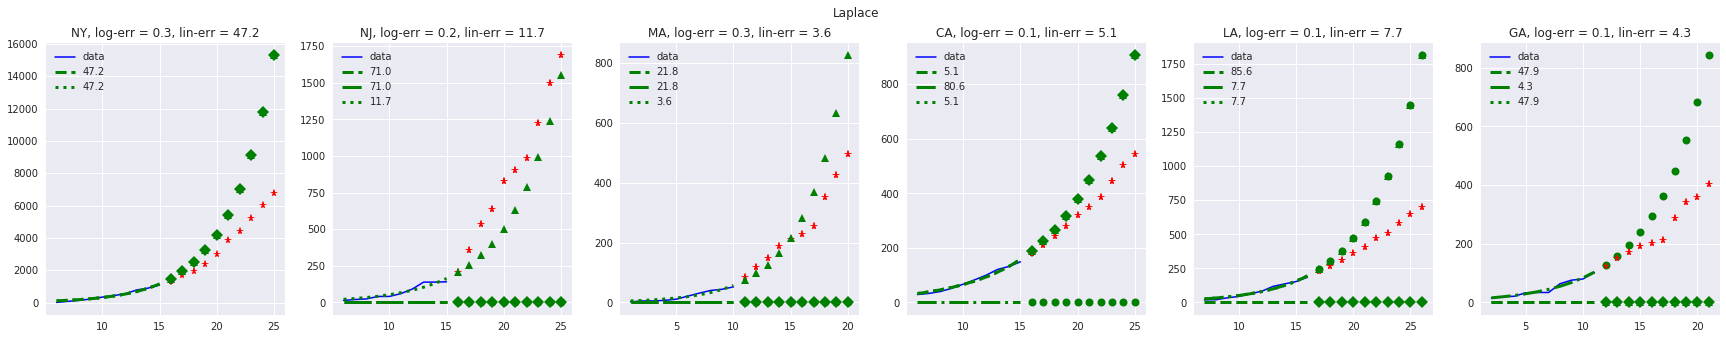

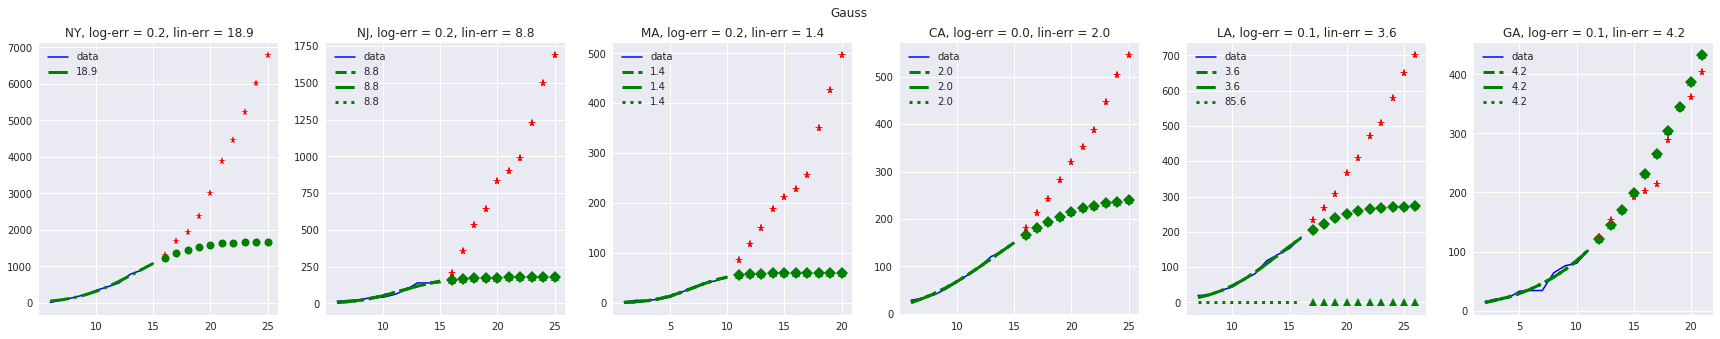

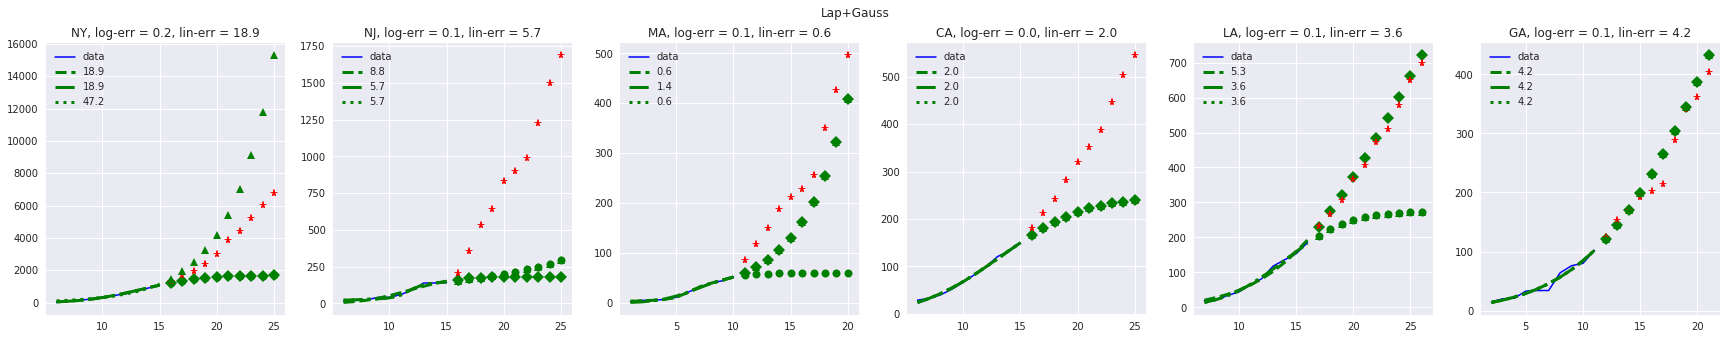

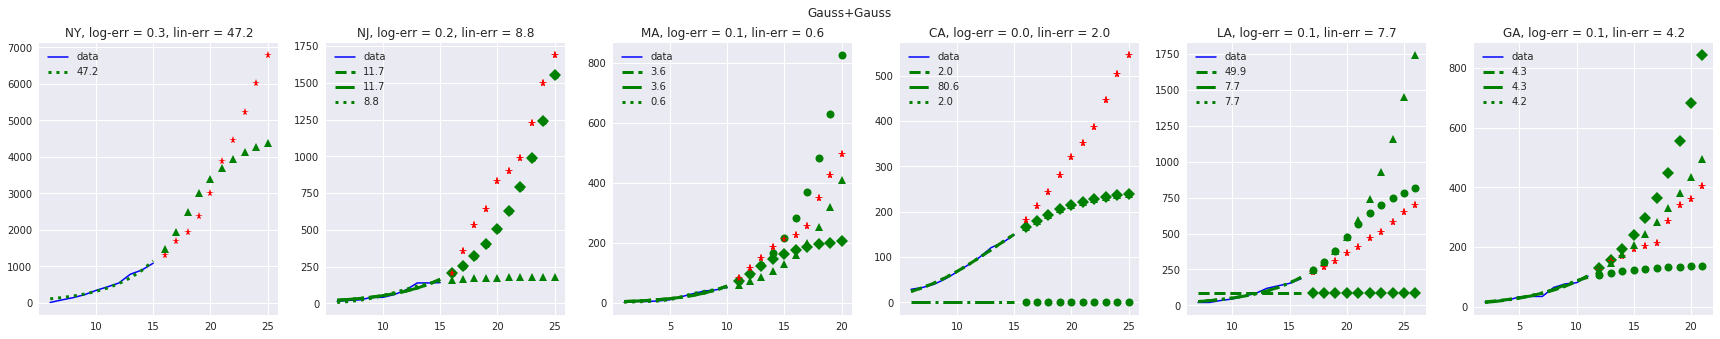

In [238]:
hold_out = 10
start = 20
for model, label in  zip([model_laplace, model_gauss, model_mixture_laplace_gaussian, model_mixture_laplace_gaussian], ['Laplace', 'Gauss', 'Lap+Gauss', 'Gauss+Gauss']):
    plt.figure(figsize=[15*2, 5])
    for j, state in enumerate(['NY', 'NJ', 'MA', 'CA', 'LA', 'GA']):
        y_full = pd.Series(sdf[sdf.state==state]["deaths"].values[0])
        rate = y_full / sdf[sdf.state==state].population.values[0]
        y_full = y_full[rate>np.exp(-16.)]
        if len(y_full)< 20:
            continue
        x_full = np.arange(0, len(y_full))
        y_train, y_test = y_full[-start:-hold_out], y_full[-hold_out:]
        x_train, x_test = x_full[-start:-hold_out], x_full[-hold_out:]
        plt.subplot(1, 6, j+1)
        plt.plot(x_train, y_train, 'b-', label='data', linewidth=1.5)  
        l1_error_log_y, l1_error = 1000., 1000. 
        for lss, mss in zip(['--', '-.', ':'], ['D', 'o', '^']):
            if len(y) > 5:
                if label=='Laplace':
                    p0 = [200000*npr.rand(), 2*npr.rand(), 100*npr.rand()]
                    bounds = [200000, 2., 100.]
                elif label == 'Lap+Gauss':
                    p0 = [100000*npr.rand(), 2*npr.rand(), 100*npr.rand(), 10000*npr.rand(), 2*npr.rand(), 10*npr.rand()]
                    bounds = [100000, 2., 100., 100000, 2., 100.]
                elif label == 'Gauss+Gauss':
                    p0 = [10000*npr.rand(), 2*npr.rand(), 5*npr.rand(), 10000*npr.rand(), 2*npr.rand(), 5*npr.rand()]
                    bounds = [100000, 2., 100., 100000, 2., 100.]
                else:
                    p0 = [20000*npr.rand(), 1*npr.rand(), 5*npr.rand()]
                    bounds = [200000, 2., 100.]
                try:
                    popt, pcov = curve_fit(model, x_train, y_train, bounds=(0., bounds), p0=p0)
                    y_fit =  model(x_train, *popt)
                    temp_log_error = np.mean(np.abs(np.log(1+y_train)-np.log(1+y_fit)))
                    temp_error = np.mean(np.abs(y_train-y_fit))
                    l1_error_log_y = min(l1_error_log_y, temp_log_error)
                    l1_error = min(l1_error, temp_error)
                    
                    if temp_error > 100:
                        continue
                    else:
                        plt.plot(x_train, y_fit, color='g', linestyle=lss, linewidth=3., label='%.1f'%temp_error)#, label='p=%.1f, a=%.1f, b=%.1f' % tuple(popt))
                        plt.plot(x_test, y_test, 'r*', markersize=8.)
                        plt.plot(x_test, model(x_test, *popt), color='g', linestyle='None',marker=mss, markersize=8.)
                    
                except:
                    continue
            plt.legend()
            plt.title('%s, log-err = %.1f, lin-err = %.1f'%(state, l1_error_log_y, l1_error))
    plt.suptitle(label)
    plt.show()

In [205]:
val_hold, test_hold = 10, 5
num_trials = 5
states = ['NY', 'NJ', 'MA', 'CA', 'LA', 'GA']
train_errors = np.zeros((len(states), num_trials, 2))
val_errors =  np.zeros((len(states), num_trials, 2))
test_errors =  np.zeros((len(states), num_trials, 2))

field = 'deaths'
for k, loss in enumerate(['linear', 'soft_l1']):
    if k == 1:
        continue
    for model, label in  zip([model_mixture_laplace_gaussian], ['Mix of Lap+Gauss']):
        for j, state in enumerate(states):
            y_full = pd.Series(sdf[sdf.state==state][field].values[0])
            rate = y_full / sdf[sdf.state==state].population.values[0]
            y_full = y_full[rate>np.exp(-15)]
            x_full = np.arange(0, len(y_full))
            y_train, y_val, y_test = y_full[:-val_hold], y_full[-val_hold:-test_hold], y_full[-test_hold:]
            x_train, y_val, x_test = x_full[:-val_hold], x_full[-val_hold:-test_hold], x_full[-test_hold:] 

            i = 0
            for _ in tqdm(range(num_trials)): 
                p0 = [100000*npr.rand(), 2*npr.rand(), 100*npr.rand(), 10000*npr.rand(), 2*npr.rand(), 10*npr.rand()]
                try:

                    popt, pcov = curve_fit(model, x_train, y_train, bounds=(0., [100000, 2., 100., 100000, 2., 100.]), p0=p0, loss=loss)
                    y_fit =  model(x_full, *popt)
                    y_train_fit, y_val_fit, y_test_fit = y_fit[:-val_hold], y_fit[-val_hold:-test_hold], y_fit[-test_hold:]

                    train_errors[j, i, k] = np.mean(np.abs(y_train-y_train_fit))
                    val_errors[j, i, k] = np.mean(np.abs(y_val-y_val_fit))
                    test_errors[j, i, k] = np.mean(np.abs(y_test-y_test_fit))
                    i += 1
                except:
                    continue


    #         plt.bar(val_errors[j, :])
    #         for lss, mss in zip(['--', '-.', ':'], ['D', 'o', '^']):
    #             p0 = [10000*npr.rand(), 2*npr.rand(), 10*npr.rand(), 10000*npr.rand(), 2*npr.rand(), 10*npr.rand()]
    #             if len(y) > 5:
    #                 popt, pcov = curve_fit(model, x_train, y_train, bounds=(0., [100000, 2., 100., 100000, 2., 100.]), p0=p0)
    #                 y_fit =  model(x_train, *popt)
    #                 plt.plot(x_train, y_fit, color='g', linestyle=lss, linewidth=3., )
    #                          #label='p=%.1f, a=%.1f, b=%.1f, p1=%.1f, a1=%.1f, b1=%.1f' % tuple(popt))
    #                 plt.plot(x_test, y_test, 'r*', markersize=8.)
    #                 plt.plot(x_test, model(x_test, *popt), color='g', linestyle='None',marker=mss, markersize=8.)
    #                 l1_error_log_y = min(l1_error_log_y, np.mean(np.abs(np.log(1+y_train)-np.log(1+y_fit))))
    #                 l1_error = min(l1_error,  np.mean(np.abs(y_train-y_fit)))
    #             plt.legend()
    #             plt.title('%s, log-err = %.1f, lin-err = %.1f'%(state, l1_error_log_y, l1_error))
    #     plt.suptitle(label)
    #     plt.show()



100%|██████████| 5/5 [00:00<00:00,  6.05it/s]


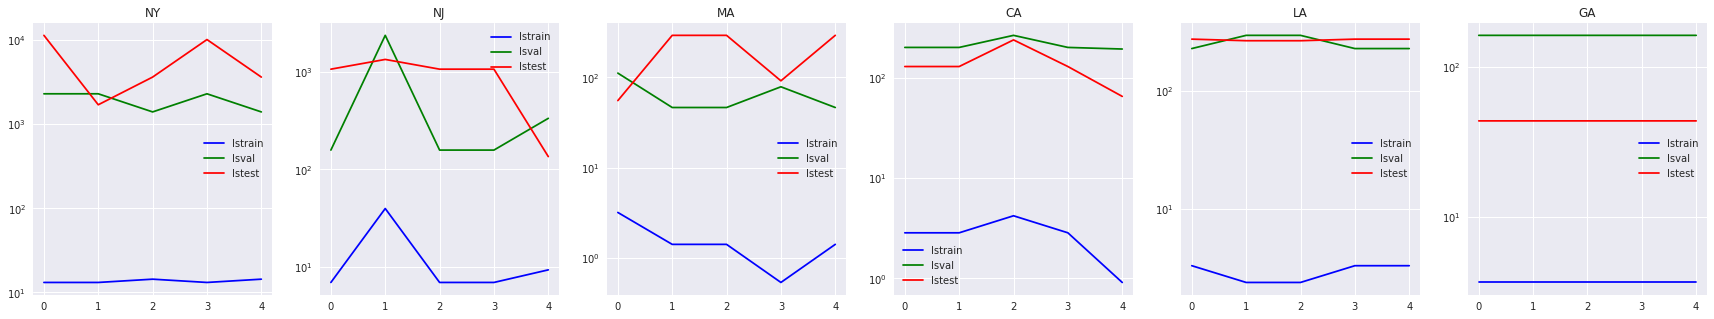

In [206]:
plt.figure(figsize=[5*len(states), 5])
for j, state in enumerate(states):
    for k, label, lss in zip(range(2), ['ls', 'l1'], ['-', '--']):
        if k==1:
            continue
        else:
            plt.subplot(1, len(states), j+1)
            plt.plot(np.arange(num_trials), train_errors[j, :, k], color='b', linestyle=lss, label=label+'train')
            plt.plot(np.arange(num_trials), val_errors[j, :, k], color='g', linestyle=lss,label=label+'val')
            plt.plot(np.arange(num_trials), test_errors[j, :, k], color='r', linestyle=lss, label=label+'test')
    plt.yscale('log')
    plt.legend()
    plt.title(state)
plt.show()

In [208]:
test_errors

array([[[11432.38653352,     0.        ],
        [ 1708.62518747,     0.        ],
        [ 3646.2227384 ,     0.        ],
        [10189.53484722,     0.        ],
        [ 3646.22079885,     0.        ]],

       [[ 1077.67078549,     0.        ],
        [ 1357.44395429,     0.        ],
        [ 1077.67351016,     0.        ],
        [ 1077.66392634,     0.        ],
        [  135.79681313,     0.        ]],

       [[   55.39685715,     0.        ],
        [  292.7609515 ,     0.        ],
        [  292.76100709,     0.        ],
        [   91.74192273,     0.        ],
        [  292.76088231,     0.        ]],

       [[  129.06215327,     0.        ],
        [  129.06182514,     0.        ],
        [  237.69894779,     0.        ],
        [  129.06199073,     0.        ],
        [   65.06064101,     0.        ]],

       [[  277.13289606,     0.        ],
        [  268.78037655,     0.        ],
        [  268.71012608,     0.        ],
        [  277.13303465,  

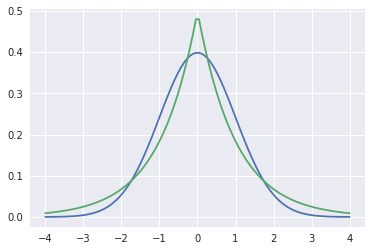

In [240]:
xx = np.linspace(-4, 4, 100)
plt.plot(xx, normal.pdf(xx))
plt.plot(xx, laplace.pdf(xx))
plt.show()

In [263]:
y_train.values

array([ 29,  33,  40,  52,  67,  83, 100, 121, 132, 149])

100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


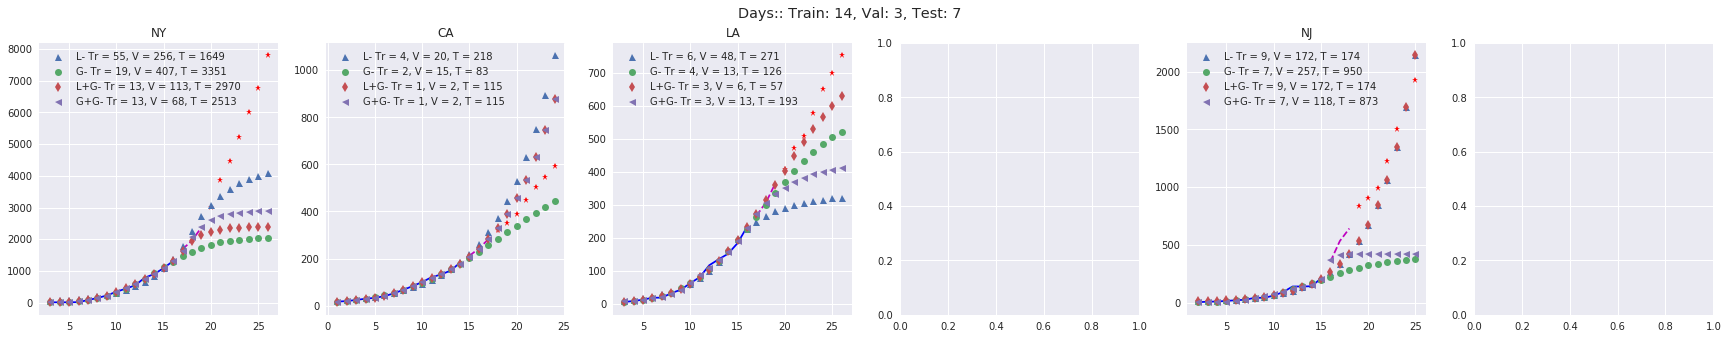

100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


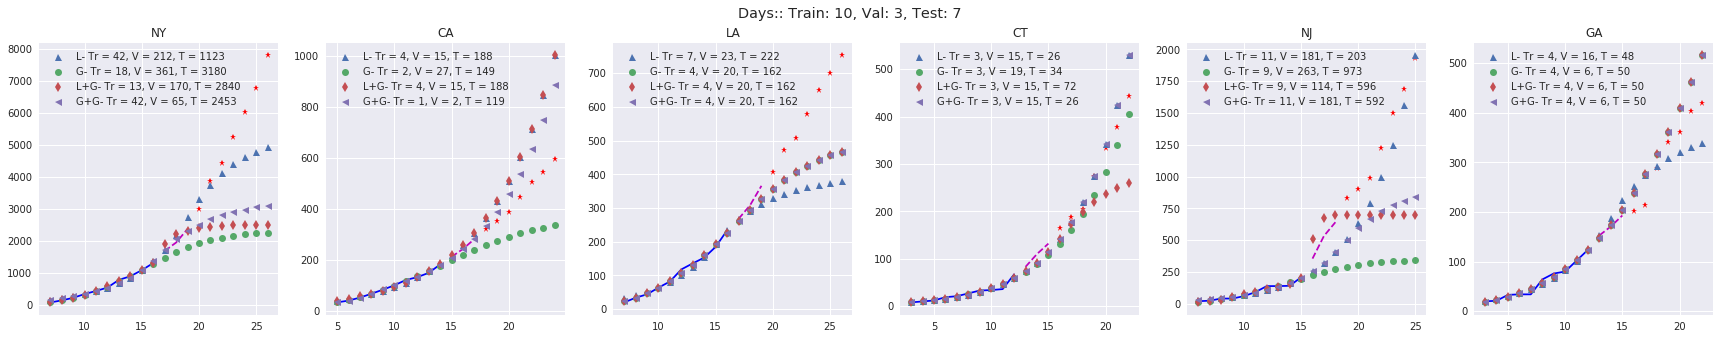

100%|██████████| 20/20 [00:03<00:00,  5.88it/s]


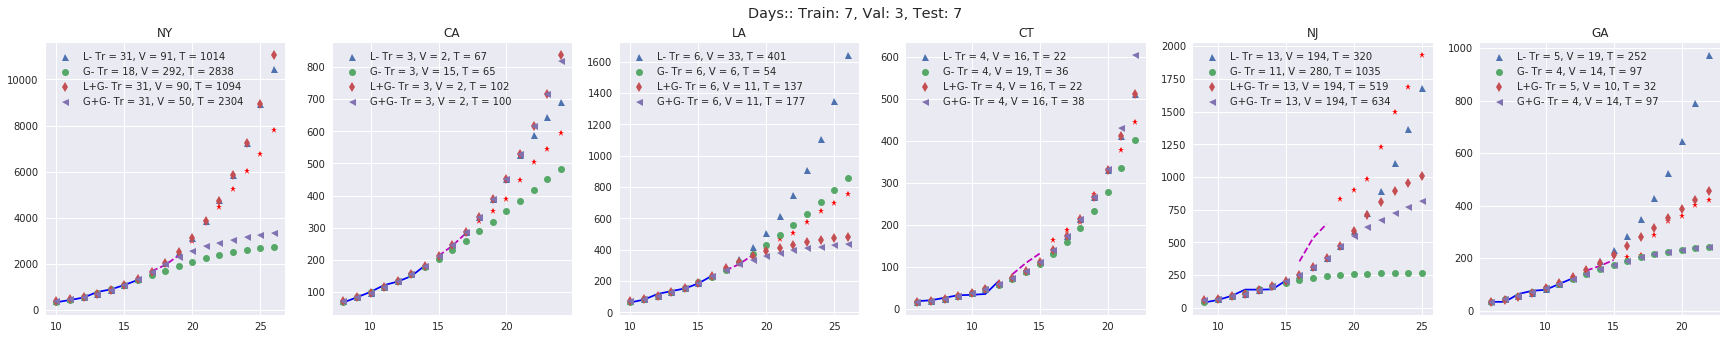

In [37]:
thres = True
val_num, test_num = 3, 7
for train_num in [14, 10, 7]: 
    num_trials = 20
    models = [model_laplace, model_gauss, model_mixture_laplace_gaussian, model_mixture_laplace_gaussian]
    labels = ['L', 'G', 'L+G', 'G+G']

    plt.figure(figsize=[30, 5])
    for j, state in enumerate(['NY', 'CA', 'LA', 'CT', 'NJ', 'GA']):
        plt.subplot(1, 6, j+1)
        y_full = np.asarray(sdf[sdf.state==state]["deaths"].values[0])
        rate = y_full / sdf[sdf.state==state].population.values[0]
        if thres:
            y_full = y_full[rate>np.exp(-15)]
        x_full = np.arange(0, len(y_full))

        if(len(y_full) < train_num + val_num + test_num):
            continue

        y_train, y_val, y_test = y_full[-(train_num+val_num+test_num):-(val_num+test_num)], y_full[-(val_num+test_num):-test_num], y_full[-test_num:]
        x_train, x_val, x_test = x_full[-(train_num+val_num+test_num):-(val_num+test_num)], x_full[-(val_num+test_num):-test_num], x_full[-test_num:] 
        # models = models[:1]
        # labels = labels[:1]

        # train_errs = dict()
        # val_errs = dict()
        # test_errs = dict()

        fit_vals = dict()
        mod_labs = dict()
        for model, label in zip(models, labels):
            fit_vals[label] = np.zeros_like(y_full)
            mod_labs[label] = None
            min_val_err = 10000.
            for _ in tqdm(range(num_trials)):
                if label=='L':
                    p0 = [200000*npr.rand()*npr.rand(), 2*npr.rand(), 100*npr.rand()*npr.rand()]
                    bounds = [200000, 2., 100.]
                elif label == 'L+G':
                    p0 = [100000*npr.rand()*npr.rand(), 2*npr.rand(), 100*npr.rand()*npr.rand(), 10000*npr.rand()*npr.rand(), 2*npr.rand(), 10*npr.rand()]
                    bounds = [100000, 2., 100., 100000, 2., 100.]
                elif label == 'G+G':
                    p0 = [10000*npr.rand()*npr.rand(), 2*npr.rand(), 5*npr.rand(), 10000*npr.rand()*npr.rand(), 2*npr.rand(), 5*npr.rand()]
                    bounds = [100000, 2., 100., 100000, 2., 100.]
                else:
                    p0 = [20000*npr.rand(), 1*npr.rand(), 5*npr.rand()]
                    bounds = [200000, 2., 100.]
                try:
                    popt, pcov = curve_fit(model, x_train, y_train, bounds=(0., bounds), p0=p0)
                    y_fit =  model(x_full, *popt)
                    y_fit_train, y_fit_val, y_fit_test = y_fit[-(train_num+val_num+test_num):-(val_num+test_num)], y_fit[-(val_num+test_num):-test_num], y_fit[-test_num:]

                    train_err, val_err, test_err = np.mean(np.abs(y_train-y_fit_train)), np.mean(np.abs(y_val-y_fit_val)) , np.mean(np.abs(y_test-y_fit_test))
                    if val_err <= min_val_err:
                        fit_vals[label] = y_fit
                        mod_labs[label] = tuple([train_err, val_err, test_err])
                        min_val_err = val_err
                except:
                    continue

        plt.plot(x_train, y_train, 'b-')
        plt.plot(x_val, y_val, 'm--')
        plt.plot(x_test, y_test, 'r*')
        start = -(train_num+val_num+test_num)
        for lab, mss in zip(labels, ['^', 'o', 'd', '<']):
            try:
                plt.plot(x_full[start:], fit_vals[lab][start:], linestyle='None', marker=mss, label=lab+'- Tr = %d, V = %d, T = %d'%mod_labs[lab])
            except:
                continue
        # plt.yscale('log')
        plt.legend()
        plt.title(state)
    plt.suptitle('Days:: Train: %d, Val: %d, Test: %d'%(train_num, val_num, test_num))
    plt.show()

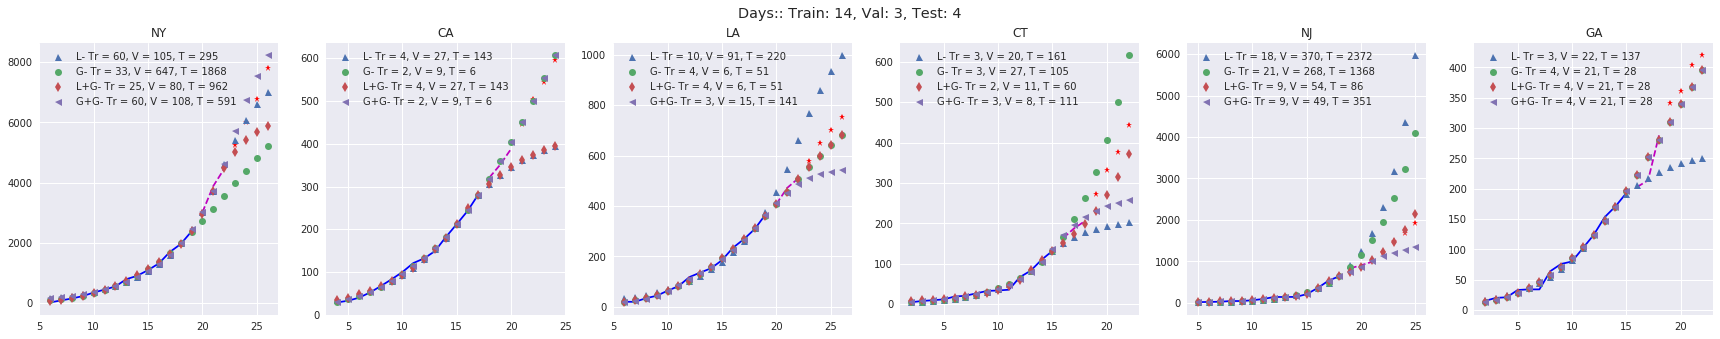

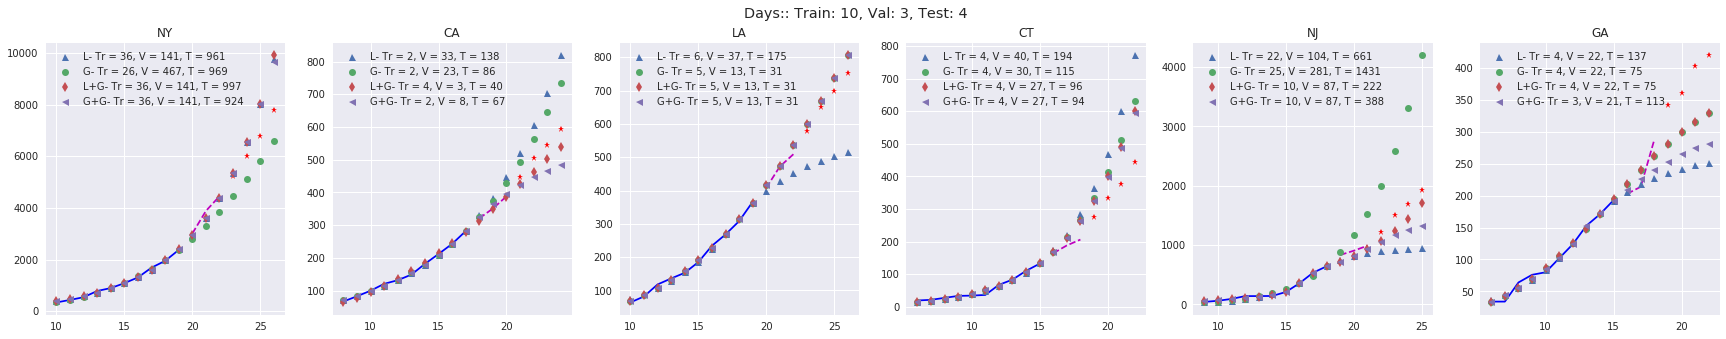

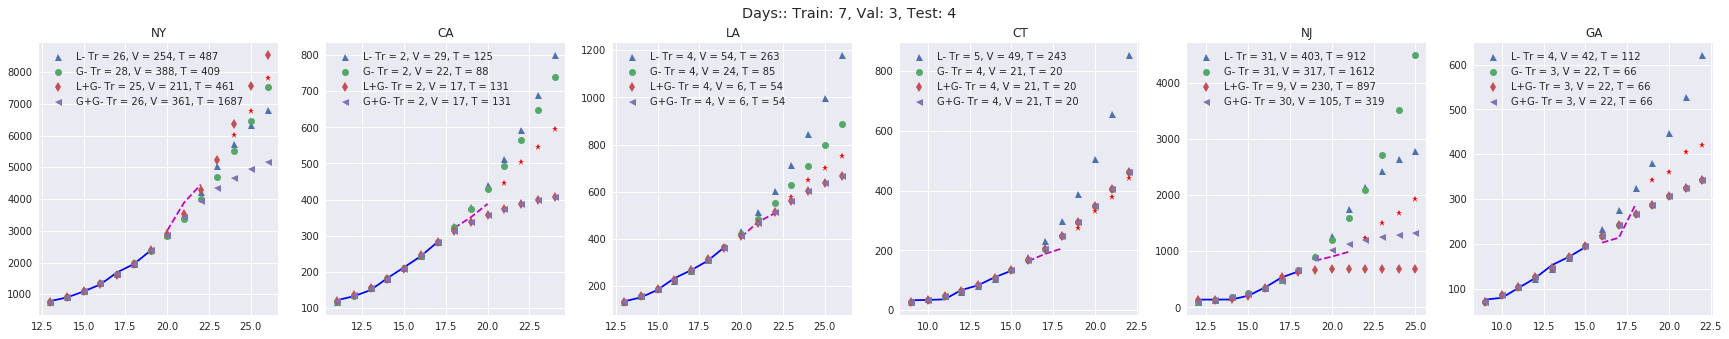

In [38]:
thres = True
val_num, test_num = 3, 4
for train_num in [14, 10, 7]: 
    num_trials = 20
    models = [model_laplace, model_gauss, model_mixture_laplace_gaussian, model_mixture_laplace_gaussian]
    labels = ['L', 'G', 'L+G', 'G+G']

    plt.figure(figsize=[30, 5])
    for j, state in enumerate(['NY', 'CA', 'LA', 'CT', 'NJ', 'GA']):
        plt.subplot(1, 6, j+1)
        y_full = np.asarray(sdf[sdf.state==state]["deaths"].values[0])
        rate = y_full / sdf[sdf.state==state].population.values[0]
        if thres:
            y_full = y_full[rate>np.exp(-15)]
        x_full = np.arange(0, len(y_full))

        if(len(y_full) < train_num + val_num + test_num):
            continue

        y_train, y_val, y_test = y_full[-(train_num+val_num+test_num):-(val_num+test_num)], y_full[-(val_num+test_num):-test_num], y_full[-test_num:]
        x_train, x_val, x_test = x_full[-(train_num+val_num+test_num):-(val_num+test_num)], x_full[-(val_num+test_num):-test_num], x_full[-test_num:] 
        # models = models[:1]
        # labels = labels[:1]

        # train_errs = dict()
        # val_errs = dict()
        # test_errs = dict()

        fit_vals = dict()
        mod_labs = dict()
        for model, label in zip(models, labels):
            fit_vals[label] = np.zeros_like(y_full)
            mod_labs[label] = None
            min_val_err = 10000.
            for _ in range(num_trials):
                if label=='L':
                    p0 = [200000*npr.rand()*npr.rand(), 2*npr.rand(), 100*npr.rand()*npr.rand()]
                    bounds = [200000, 2., 100.]
                elif label == 'L+G':
                    p0 = [100000*npr.rand()*npr.rand(), 2*npr.rand(), 100*npr.rand()*npr.rand(), 10000*npr.rand()*npr.rand(), 2*npr.rand(), 10*npr.rand()]
                    bounds = [100000, 2., 100., 100000, 2., 100.]
                elif label == 'G+G':
                    p0 = [10000*npr.rand()*npr.rand(), 2*npr.rand(), 5*npr.rand(), 10000*npr.rand()*npr.rand(), 2*npr.rand(), 5*npr.rand()]
                    bounds = [100000, 2., 100., 100000, 2., 100.]
                else:
                    p0 = [20000*npr.rand(), 1*npr.rand(), 5*npr.rand()]
                    bounds = [200000, 2., 100.]
                try:
                    popt, pcov = curve_fit(model, x_train, y_train, bounds=(0., bounds), p0=p0)
                    y_fit =  model(x_full, *popt)
                    y_fit_train, y_fit_val, y_fit_test = y_fit[-(train_num+val_num+test_num):-(val_num+test_num)], y_fit[-(val_num+test_num):-test_num], y_fit[-test_num:]

                    train_err, val_err, test_err = np.mean(np.abs(y_train-y_fit_train)), np.mean(np.abs(y_val-y_fit_val)) , np.mean(np.abs(y_test-y_fit_test))
                    if val_err <= min_val_err:
                        fit_vals[label] = y_fit
                        mod_labs[label] = tuple([train_err, val_err, test_err])
                        min_val_err = val_err
                except:
                    continue

        plt.plot(x_train, y_train, 'b-')
        plt.plot(x_val, y_val, 'm--')
        plt.plot(x_test, y_test, 'r*')
        start = -(train_num+val_num+test_num)
        for lab, mss in zip(labels, ['^', 'o', 'd', '<']):
            try:
                plt.plot(x_full[start:], fit_vals[lab][start:], linestyle='None', marker=mss, label=lab+'- Tr = %d, V = %d, T = %d'%mod_labs[lab])
            except:
                continue
        # plt.yscale('log')
        plt.legend()
        plt.title(state)
    plt.suptitle('Days:: Train: %d, Val: %d, Test: %d'%(train_num, val_num, test_num))
    plt.show()

## Think about weigthing them

## Take Away So far: You can change training days and one of the four models can do an okay job